# DistilBERT on GoEmotions

In [1]:
# importing libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import classification_report
from transformers import DistilBertTokenizer, TFDistilBertModel 
from distilBERT_model_class import DistilBertClassificationModel # Imports the DiltilBERT model 
from TextCleaner import TextCleaner

In [2]:
from tensorflow import keras

from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

from sklearn.preprocessing import MultiLabelBinarizer

from datasets import load_dataset

In [3]:
dataset_name = "go_emotions"
dataset = load_dataset(dataset_name)
pd.set_option('display.max_colwidth', None)

# Convert to pandas dataframes
train_df = dataset["train"].to_pandas()
dev_df = dataset["validation"].to_pandas()
test_df = dataset["test"].to_pandas()

# Convert to pandas dataframes
train_df.columns = ["text", "emotions", "ids"]
dev_df.columns = ["text", "emotions", "ids"]
test_df.columns = ["text", "emotions", "ids"]

In [4]:
cleaner = TextCleaner(train_df, dev_df, test_df)
cleaner.clean_all() # Apply all cleaning steps

In [5]:
train_texts = train_df['text'].tolist()
dev_texts = dev_df['text'].tolist()
test_texts = test_df['text'].tolist()

In [6]:
len(train_df)

43410

In [7]:
train_df[:10]

,text,emotions,ids
0,my favourite food is anything i did not have to cook myself,[27],eebbqej
1,now if he does off himself everyone will think hes having a laugh screwing with people instead of actually dead,[27],ed00q6i
2,why the fuck is bayless isoing,[2],eezlygj
3,to make her feel threatened,[14],ed7ypvh
4,dirty southern wankers,[3],ed0bdzj
5,omg peyton is not good enough to help us in the playoffs dumbass broncos fans circa december 2015,[26],edvnz26
6,yes i heard about the f bombs that has to be why thanks for your reply until then hubby and i will anxiously wait 😝,[15],ee3b6wu
7,we need more boards and to create a bit more space for [NAME] then we will be good,"[8, 20]",ef4qmod
8,damn youtube and outrage drama is super lucrative for reddit,[0],ed8wbdn
9,it might be linked to the trust factor of your friend,[27],eczgv1o


In [8]:
train_labels = train_df['emotions'].tolist()
dev_labels = dev_df['emotions'].tolist()
test_labels = test_df['emotions'].tolist()

mlb = MultiLabelBinarizer()
train_labels_bin = mlb.fit_transform(train_labels)
dev_labels_bin = mlb.transform(dev_labels)
test_labels_bin = mlb.transform(test_labels)

In [9]:
train_labels_bin[:5]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0]])

In [10]:
train_labels_bin.shape

(43410, 28)

In [11]:
emotion_mapping = {
    '0' : 'admiration',
    '1' : 'amusement',
    '2' : 'anger',
    '3' : 'annoyance',
    '4' : 'approval',
    '5' : 'caring',
    '6' : 'confusion',
    '7' : 'curiosity',
    '8' : 'desire',
    '9': 'disappointment',
    '10': 'disapproval',
    '11': 'disgust',
    '12': 'embarrassment',
    '13': 'excitement',
    '14': 'fear',
    '15': 'gratitude',
    '16': 'grief',
    '17': 'joy',
    '18': 'love',
    '19': 'nervousness',
    '20': 'optimism',
    '21': 'pride',
    '22': 'realization',
    '23': 'relief',
    '24': 'remorse',
    '25': 'sadness',
    '26': 'surprise',
    '27': 'neutral'
}

target_names = list(emotion_mapping.values())
print(target_names)

['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise', 'neutral']


In [12]:
# DistilBERT Tokenization
model_checkpoint = 'distilbert-base-cased'
distilbert_tokenizer = DistilBertTokenizer.from_pretrained(model_checkpoint)

In [13]:
max_length = 128  # max length of input sequence

train_encodings = distilbert_tokenizer(train_texts, truncation=True, padding='max_length', max_length=max_length, return_tensors='tf')
dev_encodings = distilbert_tokenizer(dev_texts, truncation=True, padding='max_length', max_length=max_length, return_tensors='tf')
test_encodings = distilbert_tokenizer(test_texts, truncation=True, padding='max_length', max_length=max_length, return_tensors='tf')

2023-11-22 21:45:32.240918: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-22 21:45:33.740396: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 45280 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:c3:00.0, compute capability: 8.0


In [14]:
train_encodings.input_ids[1]

<tf.Tensor: shape=(128,), dtype=int32, numpy=
array([  101,  1208,  1191,  1119,  1674,  1228,  1471,  2490,  1209,
        1341,  1119,  1116,  1515,   170,  4046, 13084,  1158,  1114,
        1234,  1939,  1104,  2140,  2044,   102,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,   

In [15]:
# DistilBERT Model
model_checkpoint = 'distilbert-base-cased'
distil_bert_classifier = DistilBertClassificationModel(checkpoint = model_checkpoint, max_length = 128)
model = distil_bert_classifier.model

2023-11-22 21:45:41.751002: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_transform.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint 

In [16]:
# confirm all layers are frozen
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 128)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 128)]        0           []                               
                                                                                                  
 tf_distil_bert_model (TFDistil  TFBaseModelOutput(l  65190912   ['attention_mask_layer[0][0]',   
 BertModel)                     ast_hidden_state=(N               'input_ids_layer[0][0]']        
                                one, 128, 768),                                               

In [17]:
distilBERT_model_history = model.fit(
    [train_encodings.input_ids, train_encodings.attention_mask],
    train_labels_bin,  # Using binarized labels
    validation_data=(
        [dev_encodings.input_ids, dev_encodings.attention_mask],
        dev_labels_bin  # Using binarized labels
    ),
    batch_size=16,
    epochs=4
)

Epoch 1/4
2714/2714 [==============================] - 144s 51ms/step - loss: 0.1008 - accuracy: 0.5184 - val_loss: 0.0874 - val_accuracy: 0.5544
Epoch 2/4
2714/2714 [==============================] - 139s 51ms/step - loss: 0.0807 - accuracy: 0.5920 - val_loss: 0.0882 - val_accuracy: 0.5459
Epoch 3/4
2714/2714 [==============================] - 138s 51ms/step - loss: 0.0661 - accuracy: 0.6624 - val_loss: 0.0910 - val_accuracy: 0.5560
Epoch 4/4
2714/2714 [==============================] - 137s 51ms/step - loss: 0.0495 - accuracy: 0.7470 - val_loss: 0.1032 - val_accuracy: 0.5461


In [18]:
 # test the model on the test set and print the neccessary results
score = model.evaluate([test_encodings.input_ids, test_encodings.attention_mask],
                                                  test_labels_bin)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

170/170 [==============================] - 5s 29ms/step - loss: 0.1040 - accuracy: 0.5423
Test loss: 0.10398132354021072
Test accuracy: 0.5422885417938232


In [19]:
# run predict for the first three elements in the test data set
# predictions = model.predict([test_encodings.input_ids[:3], test_encodings.attention_mask[:3]])

In [20]:
#run and capture all predictions from our test set using model.predict
predictions_model1 = model.predict([test_encodings.input_ids, test_encodings.attention_mask])

threshold = 0.3
binary_predictions = (predictions_model1 > threshold).astype(int)

170/170 [==============================] - 4s 17ms/step


In [21]:
print(classification_report(test_labels_bin, binary_predictions, target_names=target_names))

                precision    recall  f1-score   support

    admiration       0.73      0.60      0.66       504
     amusement       0.76      0.82      0.79       264
         anger       0.58      0.42      0.49       198
     annoyance       0.45      0.20      0.28       320
      approval       0.51      0.28      0.36       351
        caring       0.48      0.23      0.31       135
     confusion       0.40      0.33      0.36       153
     curiosity       0.50      0.34      0.40       284
        desire       0.61      0.36      0.45        83
disappointment       0.35      0.21      0.26       151
   disapproval       0.38      0.31      0.34       267
       disgust       0.68      0.36      0.47       123
 embarrassment       0.60      0.24      0.35        37
    excitement       0.51      0.35      0.42       103
          fear       0.72      0.64      0.68        78
     gratitude       0.95      0.89      0.92       352
         grief       0.00      0.00      0.00  

/global/common/software/nersc/pm-2022q4/sw/tensorflow/2.9.0/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/global/common/software/nersc/pm-2022q4/sw/tensorflow/2.9.0/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Table with Results from Experiments

| Model Name   | Max length | Hidden Units | Dropout | Learning Rate | Batch Size | Num. Epochs | Evaluation Data | Accuracy | Macro F1 Score | Precision | Recall | Total Parameters |
|--------------|------------|--------------|---------|---------------|------------|------------|-----------------|----------|----------------|-----------|--------|------------------|
| DistilBERT-cased    | 128        | N/A          | 0.1     | 0.00005       | 16         | 4          | Test Data       |        |     0.45      |    0.62   |  0.39   |    65,212,444     |


In [22]:
test_pred_labels = mlb.inverse_transform(binary_predictions) 

In [23]:
for i in range(40):
    text_example = test_texts[i]
    actual_emotion = test_df['emotions'].iloc[i]
    
    actual_labels = [emotion_mapping[str(label)] for label in actual_emotion]
    predicted_labels = [emotion_mapping[str(label)] for label in test_pred_labels[i]]

    print(f"Text: {text_example}")
    print(f"Actual Labels: {actual_labels}")
    print(f"Predicted Labels: {predicted_labels}")
    print("\n" + "="*50 + "\n")

Text: i am really sorry about your situation although i love the names sapphira cirilla and scarlett
Actual Labels: ['sadness']
Predicted Labels: ['love', 'remorse']


Text: it is wonderful because it is awful at not with
Actual Labels: ['admiration']
Predicted Labels: ['admiration']


Text: kings fan here good luck to you guys will be an interesting game to watch
Actual Labels: ['excitement']
Predicted Labels: ['optimism']


Text: i did not know that thank you for teaching me something today
Actual Labels: ['gratitude']
Predicted Labels: ['gratitude']


Text: they got bored from haunting earth for thousands of years and ultimately moved on to the afterlife
Actual Labels: ['neutral']
Predicted Labels: ['neutral']


Text: thank you for asking questions and recognizing that there may be things that you do not know or understand about police tactics seriously thank you
Actual Labels: ['gratitude']
Predicted Labels: ['gratitude']


Text: you are welcome
Actual Labels: ['gratitude']
Predict

In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

<Figure size 1000x1000 with 0 Axes>

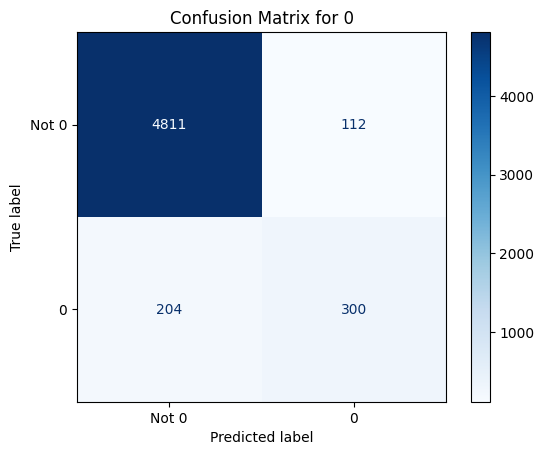

<Figure size 1000x1000 with 0 Axes>

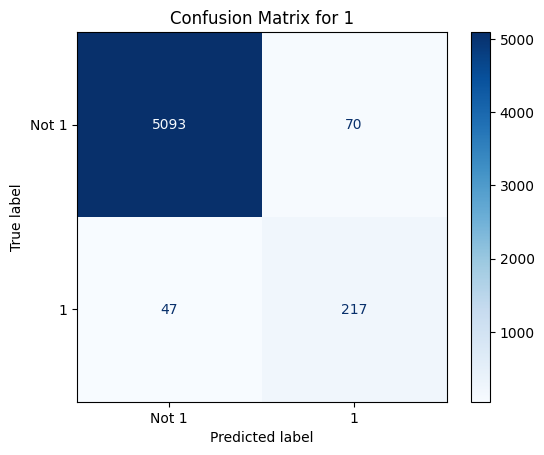

<Figure size 1000x1000 with 0 Axes>

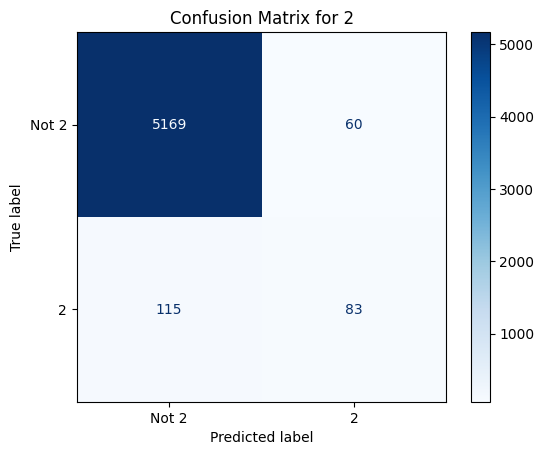

<Figure size 1000x1000 with 0 Axes>

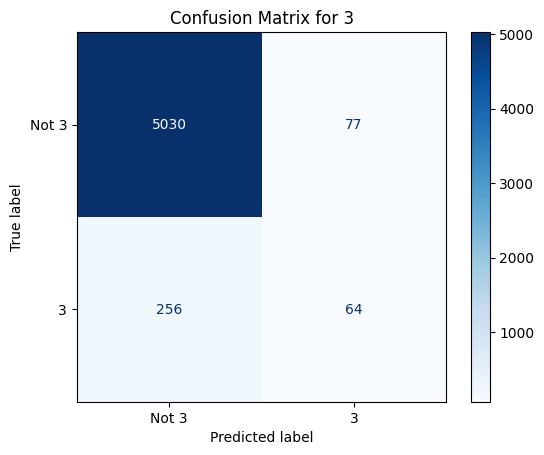

<Figure size 1000x1000 with 0 Axes>

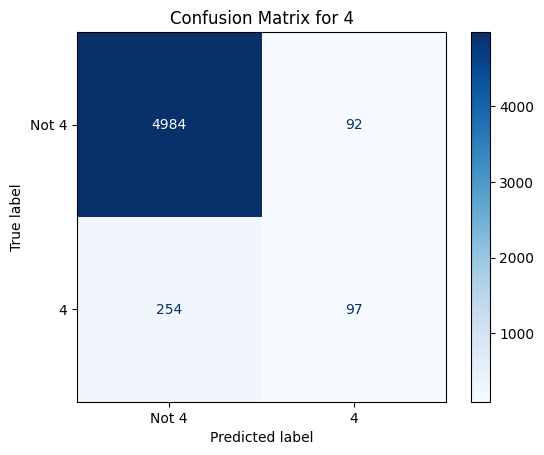

<Figure size 1000x1000 with 0 Axes>

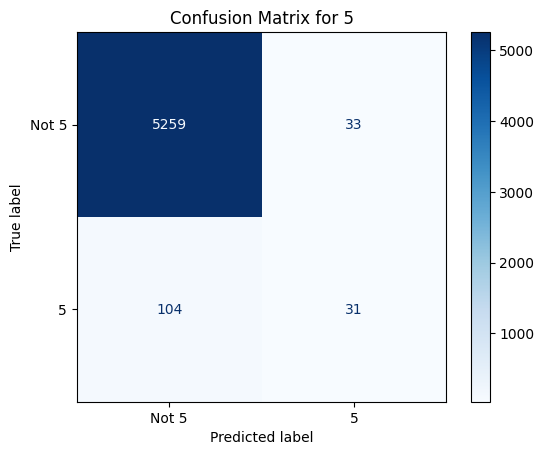

<Figure size 1000x1000 with 0 Axes>

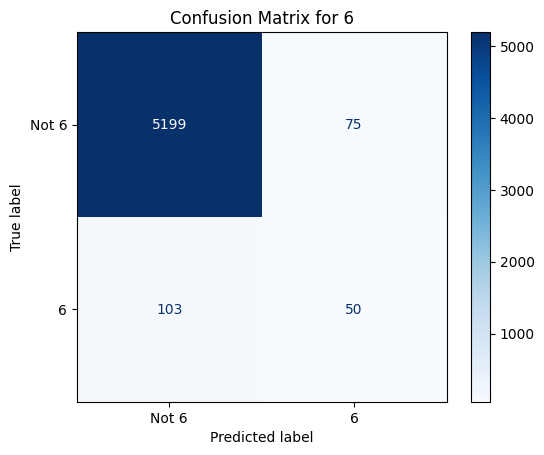

<Figure size 1000x1000 with 0 Axes>

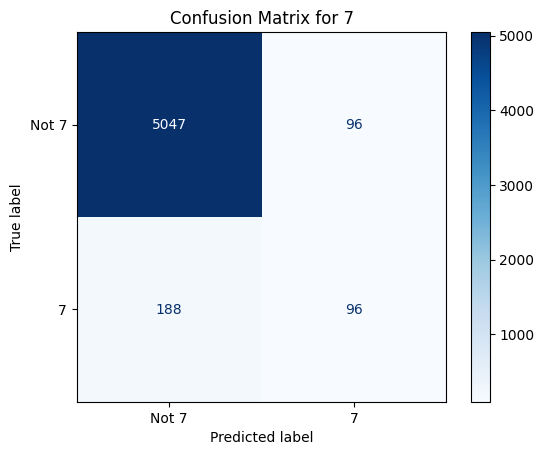

<Figure size 1000x1000 with 0 Axes>

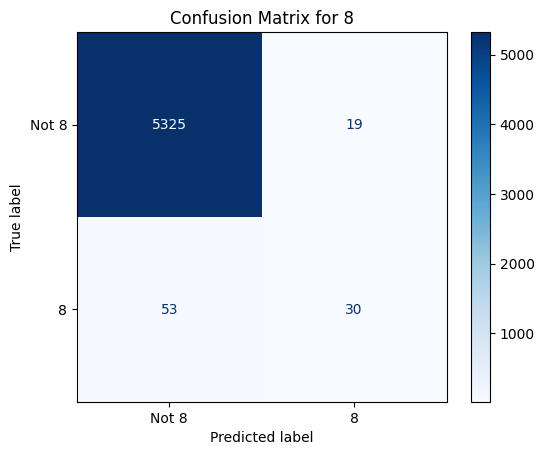

<Figure size 1000x1000 with 0 Axes>

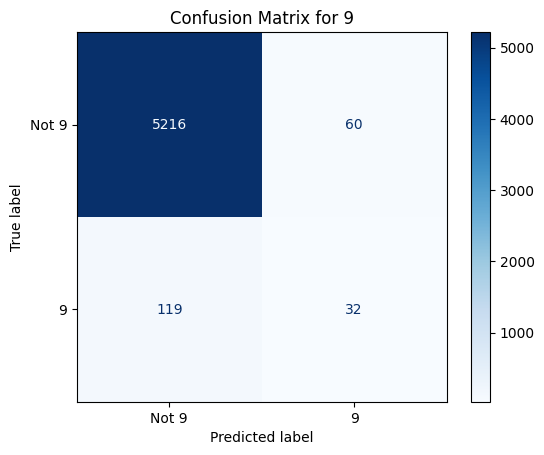

<Figure size 1000x1000 with 0 Axes>

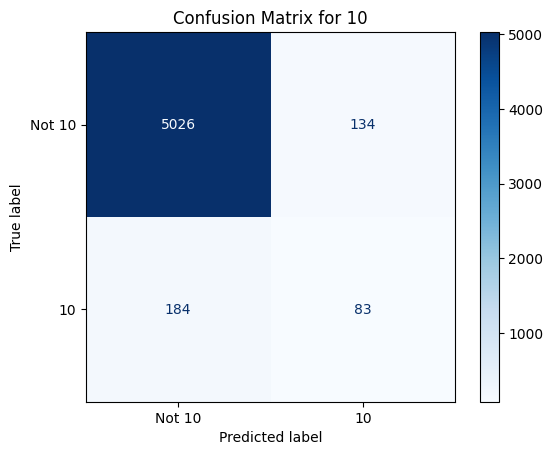

<Figure size 1000x1000 with 0 Axes>

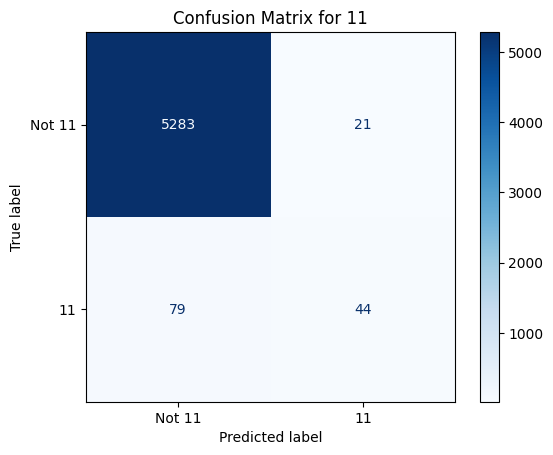

<Figure size 1000x1000 with 0 Axes>

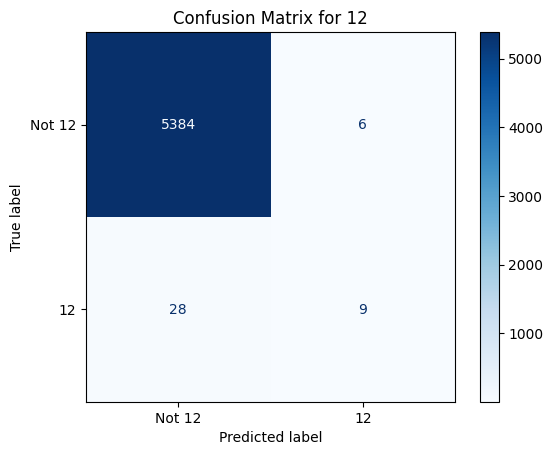

<Figure size 1000x1000 with 0 Axes>

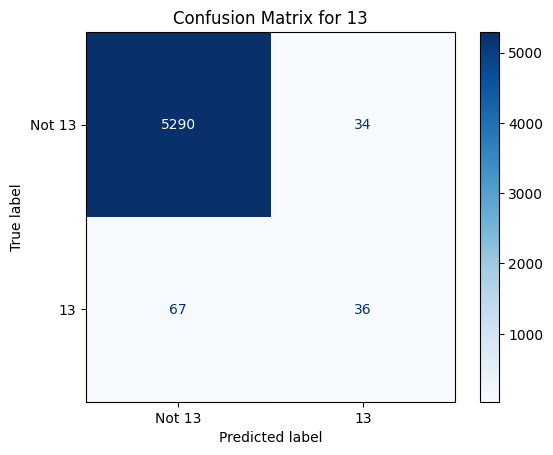

<Figure size 1000x1000 with 0 Axes>

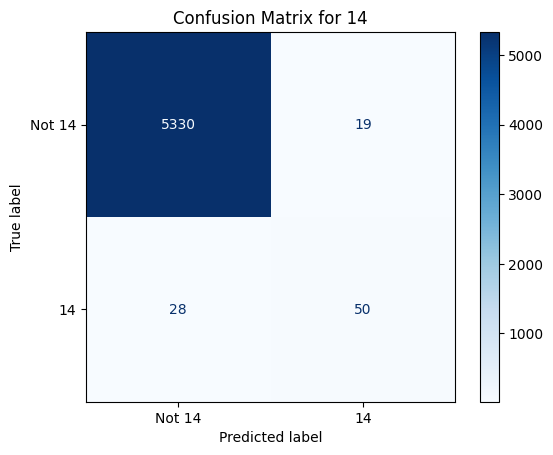

<Figure size 1000x1000 with 0 Axes>

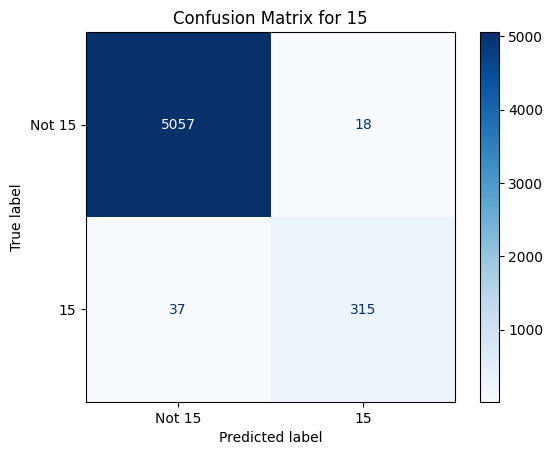

<Figure size 1000x1000 with 0 Axes>

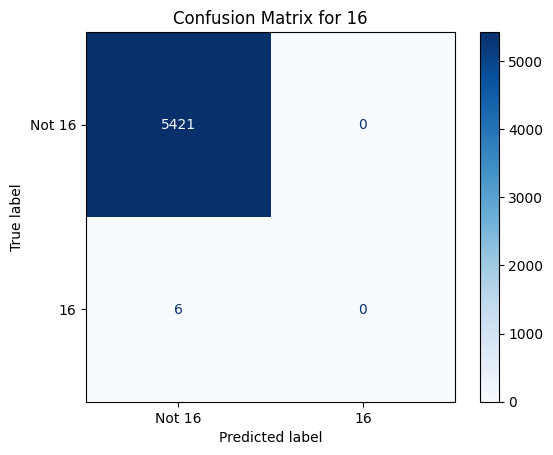

<Figure size 1000x1000 with 0 Axes>

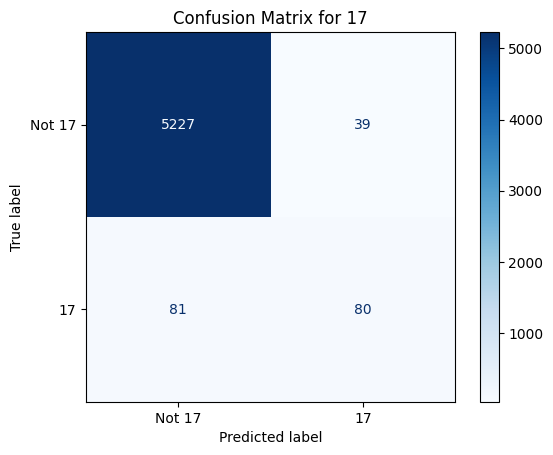

<Figure size 1000x1000 with 0 Axes>

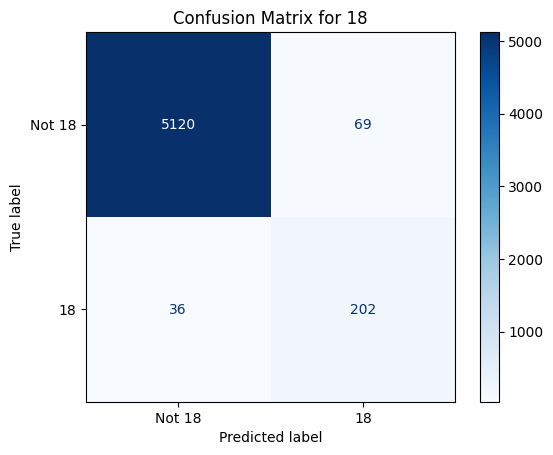

<Figure size 1000x1000 with 0 Axes>

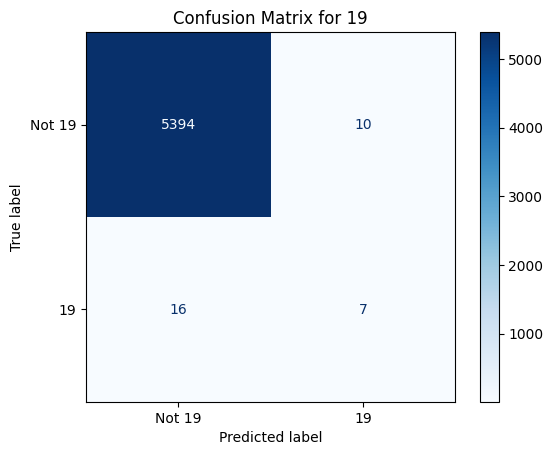

<Figure size 1000x1000 with 0 Axes>

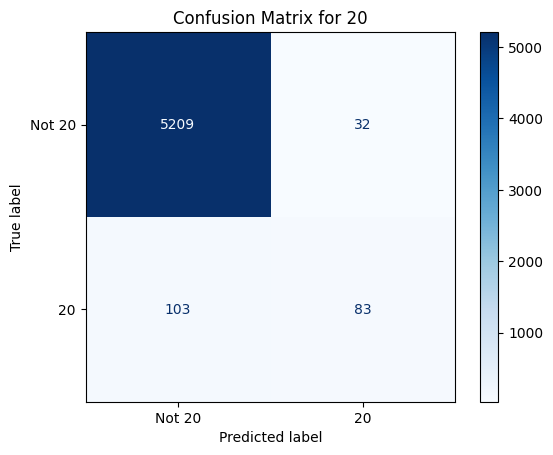

<Figure size 1000x1000 with 0 Axes>

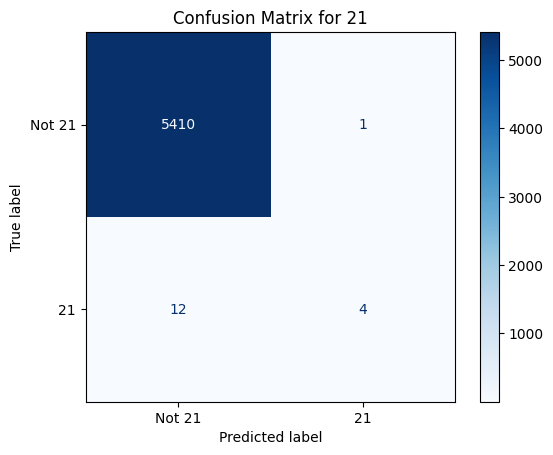

<Figure size 1000x1000 with 0 Axes>

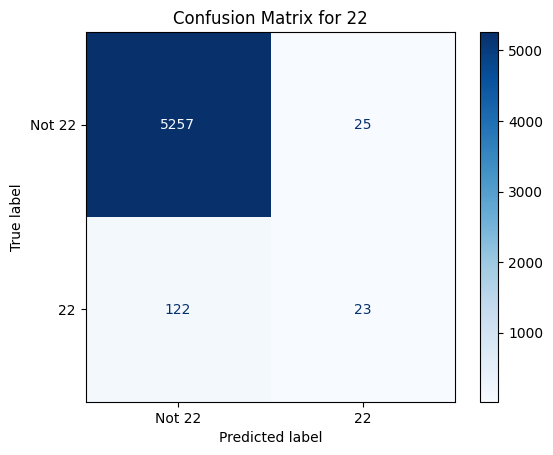

<Figure size 1000x1000 with 0 Axes>

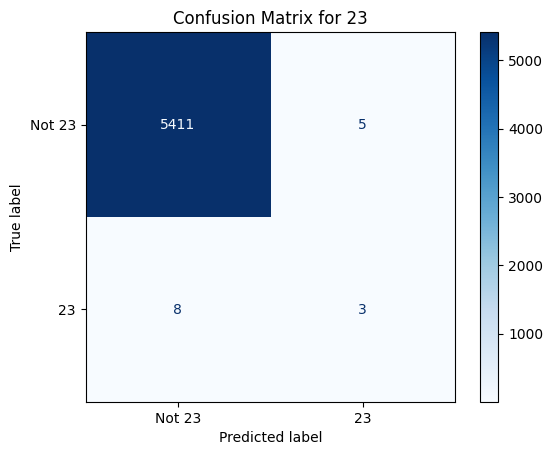

<Figure size 1000x1000 with 0 Axes>

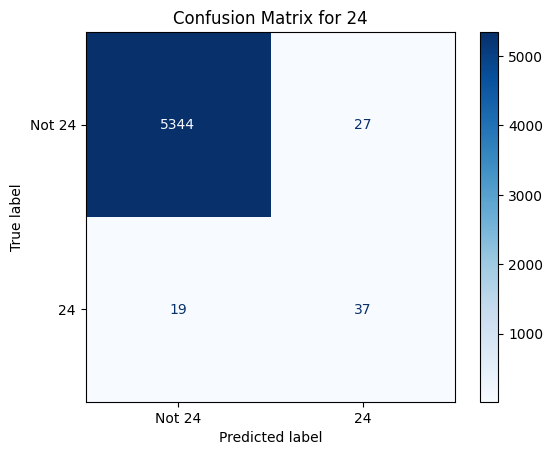

<Figure size 1000x1000 with 0 Axes>

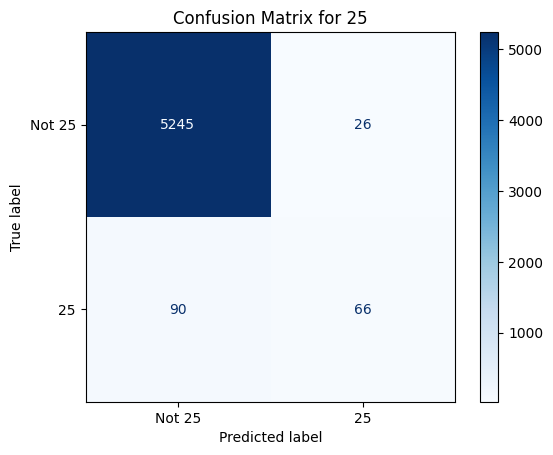

<Figure size 1000x1000 with 0 Axes>

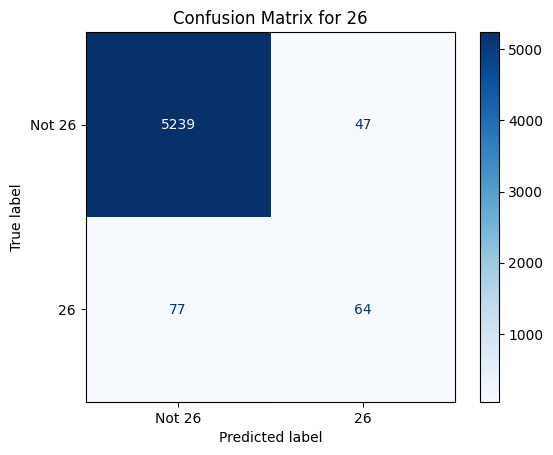

<Figure size 1000x1000 with 0 Axes>

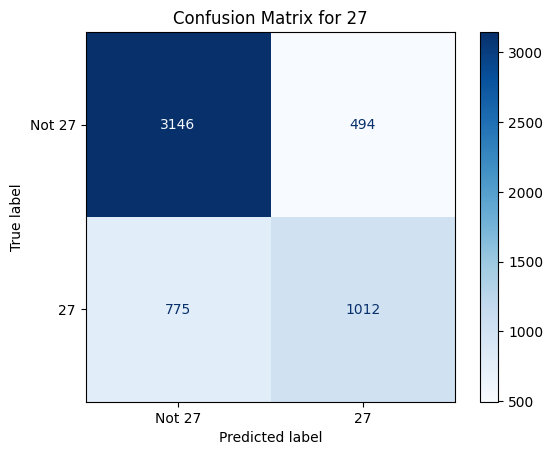

In [25]:
num_labels = len(mlb.classes_)
for i in range(num_labels):
    cm = confusion_matrix(test_labels_bin[:, i], binary_predictions[:, i])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f'Not {mlb.classes_[i]}', mlb.classes_[i]])

    plt.figure(figsize=(10,10))
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix for {mlb.classes_[i]}')
    plt.show()


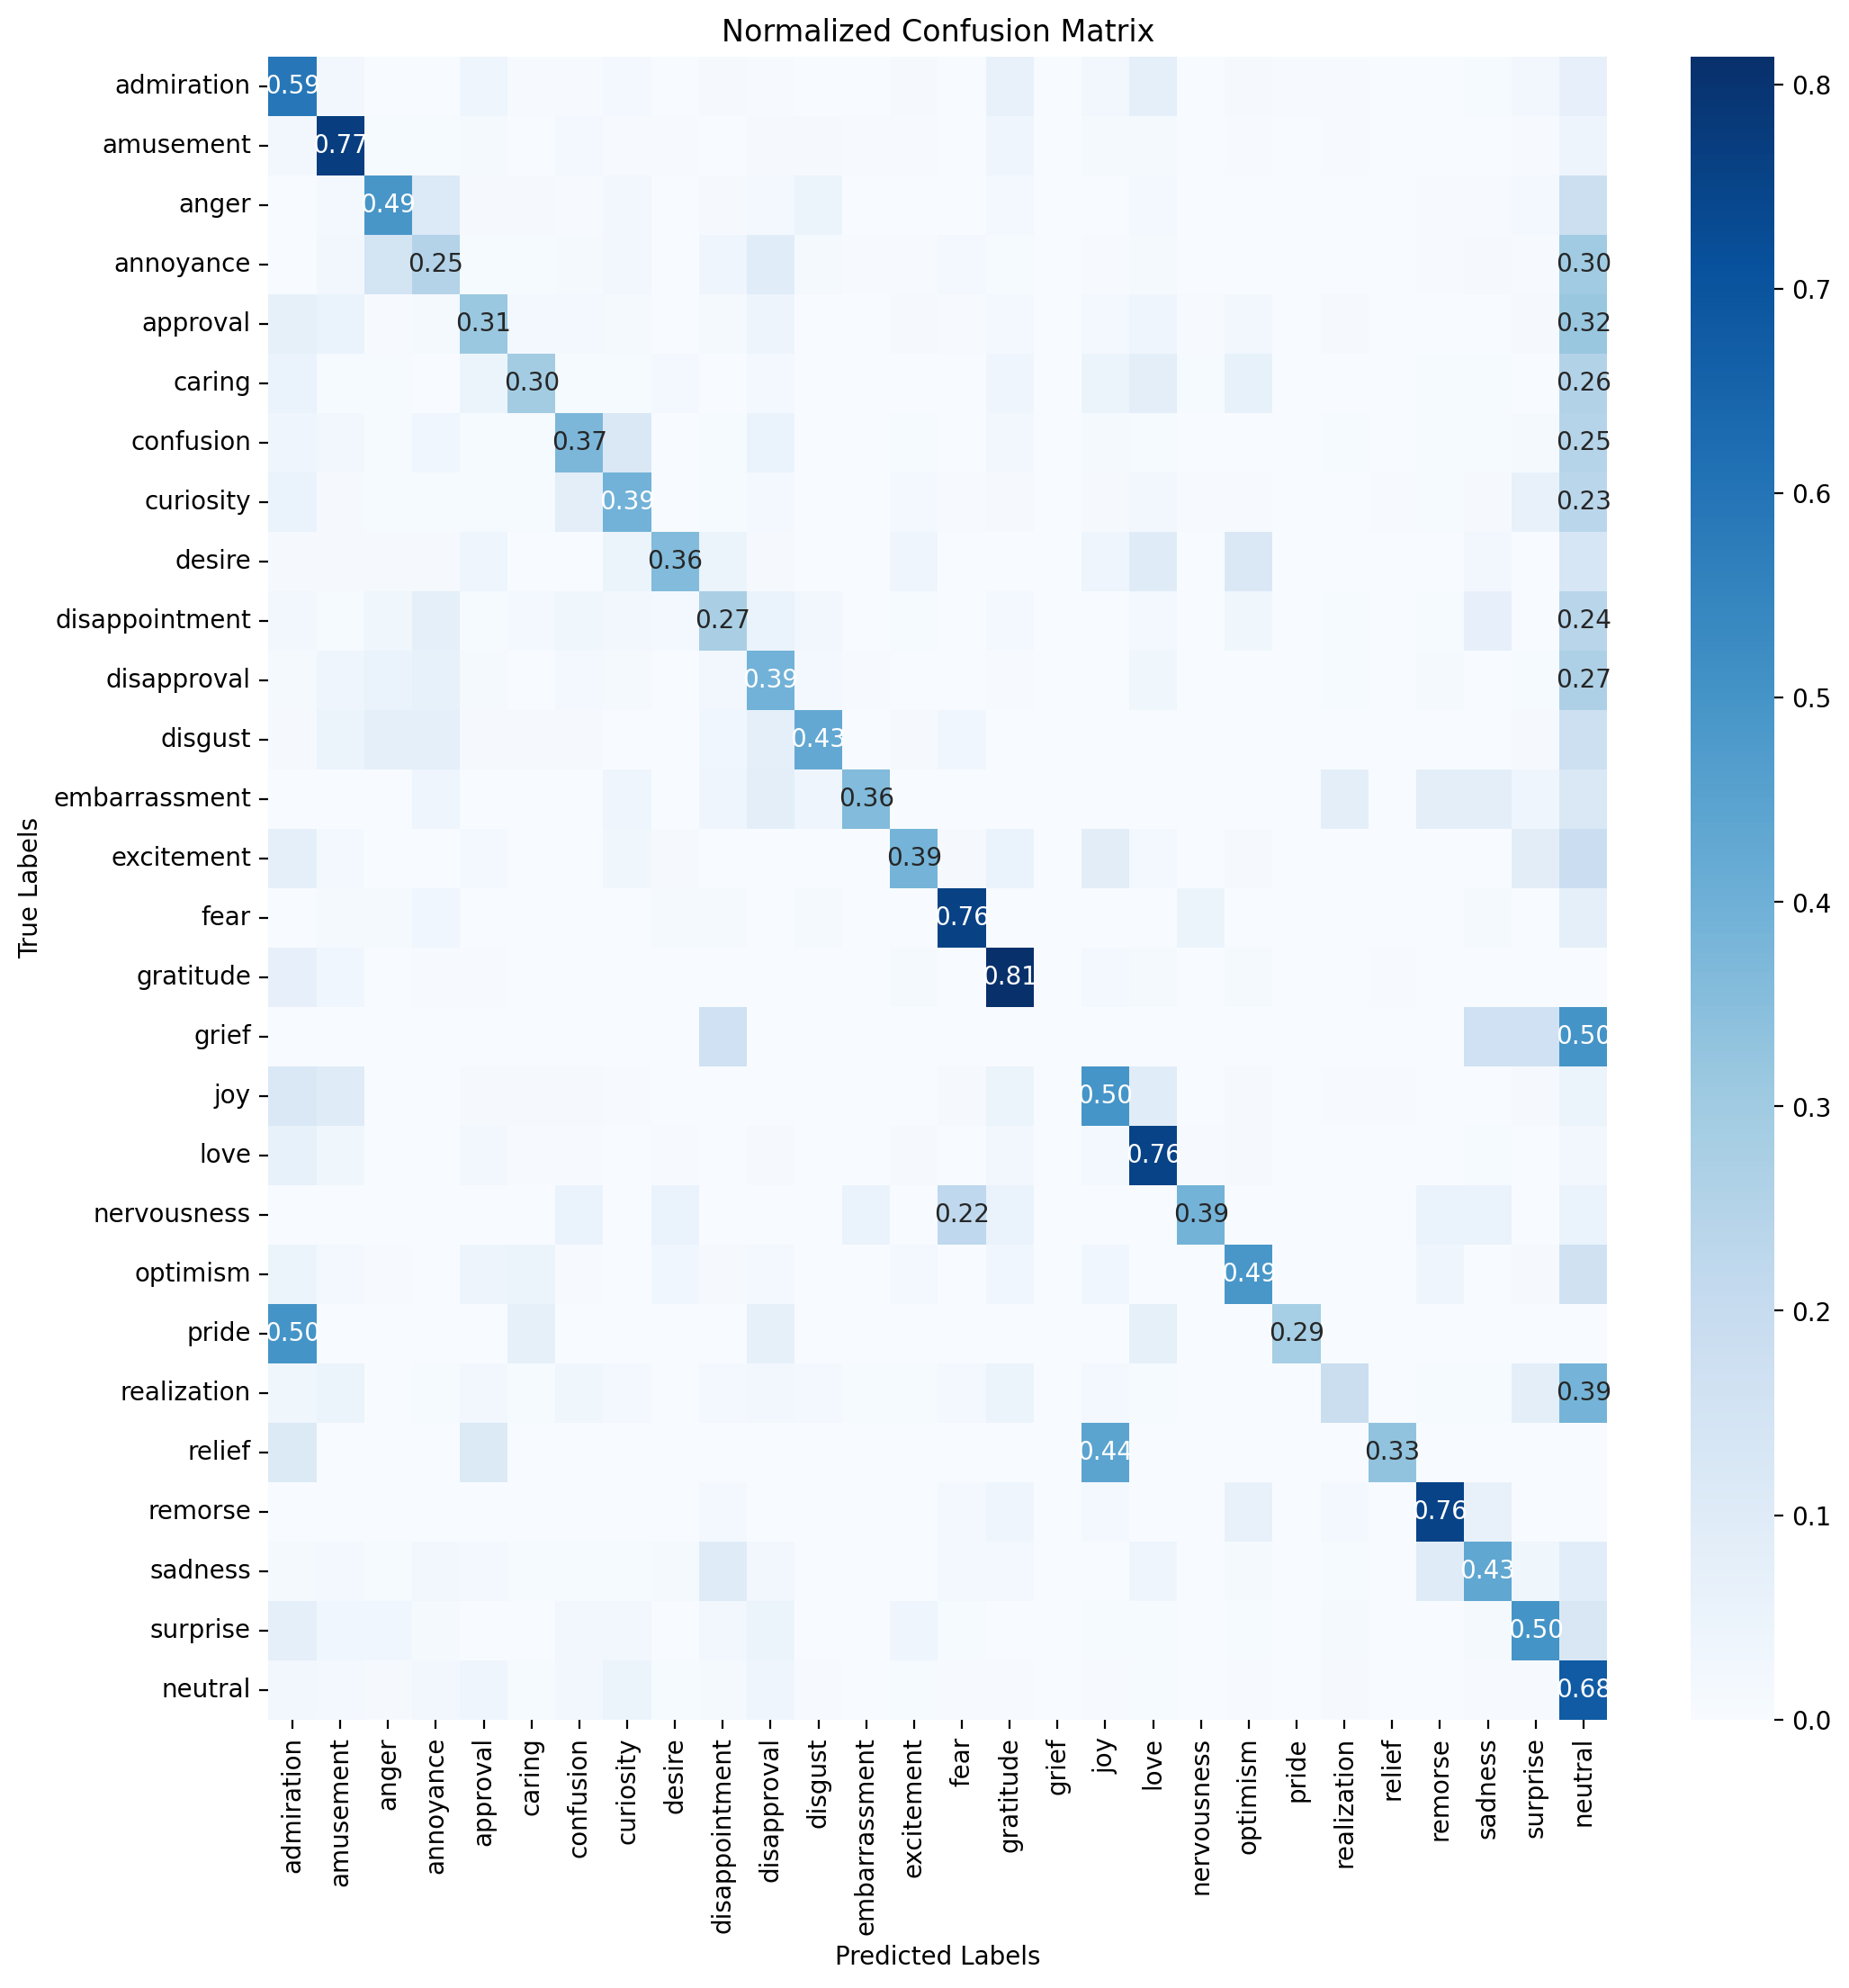

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

num_classes = 28  # Number of labels

# Initialize the confusion matrix
conf_matrix = np.zeros((num_classes, num_classes), dtype=np.int32)

# Update the matrix for each sample
for true_labels, pred_labels in zip(test_labels_bin, binary_predictions):
    for i in range(num_classes):
        if true_labels[i]:
            for j in range(num_classes):
                if pred_labels[j]:
                    conf_matrix[i, j] += 1

# Normalize the matrix
conf_matrix_normalized = conf_matrix / conf_matrix.sum(axis=1, keepdims=True)

# only keeping the values after normalizaiton which ae greater than 0.20
annotations = np.array([["" if value < 0.20 else f"{value:.2f}" for value in row] for row in conf_matrix_normalized])

# Plot the matrix
plt.figure(figsize=(12, 12), dpi=200)
sns.heatmap(conf_matrix_normalized, annot=annotations, fmt="", cmap="Blues", xticklabels=target_names, yticklabels=target_names)
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.title('Normalized Confusion Matrix')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()